# Baseline claseification

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.factory  import FactoryDataset 
from torchlib.datasets import Dataset, SecuencialSamplesDataset, TripletsDataset
from torchlib.classifierneuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)


In [3]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/netruns'
name_dataset=FactoryDataset.cifar10
no_cuda=False
seed=1
gpu=1
batch_size=60
workers=60
num_input_channels=3

print(pathname)
print(projectnet)
print(name_dataset)


/home/fernandez/.datasets
../out/netruns
cifar10


In [4]:
!ls ../out/netruns/

exp_baseline_alexnet_cross_adam_cifar10_001
exp_baseline_resnet18_cross_adam_cifar10_001
exp_baseline_simplenet_cross_adam_cifar10_001
exp_baseline_simplenet_cross_adam_ferp_001
exp_baseline_simplenet_cross_adam_mnist_001


In [5]:
name = 'exp_baseline_resnet18_cross_adam_cifar10_001'
project = os.path.join(projectnet, name)
model = 'model_best.pth.tar' #'chk001025.pth.tar'
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)


../out/netruns/exp_baseline_resnet18_cross_adam_cifar10_001
../out/netruns/exp_baseline_resnet18_cross_adam_cifar10_001/models/model_best.pth.tar


# Load model

In [6]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

=> loading checkpoint '../out/netruns/exp_baseline_resnet18_cross_adam_cifar10_001/models/model_best.pth.tar'
=> loaded checkpoint for resnet18 arch!


# Load dataset

In [7]:
data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.validation, 
        download=True ),
    num_channels=num_input_channels,
    transform=get_transforms_det(network.size_input)
    )

dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))


Files already downloaded and verified
Data loader 
167
10000


# Run

In [8]:
Yhat, Y = network.test( dataloader )
df = pd.DataFrame( np.concatenate((Yhat, Y), axis=1) )
df.to_csv( os.path.join(project , 'val_{}_dp.csv'.format(name)), index=False, encoding='utf-8')       

print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 167/167 [00:11<00:00, 14.02it/s]


dir: ../out/netruns/exp_baseline_resnet18_cross_adam_cifar10_001
DONE!!!


In [9]:
df = pd.read_csv( os.path.join(project , 'val_{}_dp.csv'.format(name))  )
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,5.977659e-13,2.570252e-10,9.551368e-08,9.999956e-01,9.373704e-12,4.319450e-06,1.982947e-09,3.539823e-09,2.002249e-14,1.350650e-15,3.0
1,1.191321e-08,2.985508e-05,3.218643e-10,5.561844e-11,5.211195e-11,1.219331e-11,2.890647e-11,3.353836e-11,9.999701e-01,7.921525e-09,8.0
2,9.473785e-08,9.947698e-01,1.560545e-08,3.453963e-11,7.124677e-07,1.391863e-09,5.942684e-08,4.355155e-08,5.206798e-03,2.256745e-05,8.0
3,9.998685e-01,1.087181e-06,4.534490e-05,5.551858e-07,1.465503e-11,2.699355e-09,6.830940e-09,3.625955e-09,4.004708e-05,4.446632e-05,0.0
4,2.242648e-10,3.792961e-07,1.114577e-05,1.370635e-07,1.331411e-08,2.394821e-10,9.999882e-01,2.270148e-11,1.829230e-11,7.265218e-08,6.0


In [10]:
result = df.as_matrix()
yhat = np.argmax( result[:,:-1], axis=1 )
y = result[:,-1]

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")



Accuracy : 0.956600
Precision : 0.956669
Recall : 0.956600
F1 score : 0.956635



In [11]:
metric = metrics.classification_report(y, yhat)
print(metric)

             precision    recall  f1-score   support

        0.0       0.97      0.96      0.96      1000
        1.0       0.98      0.98      0.98      1000
        2.0       0.95      0.95      0.95      1000
        3.0       0.93      0.89      0.91      1000
        4.0       0.95      0.96      0.96      1000
        5.0       0.91      0.93      0.92      1000
        6.0       0.97      0.97      0.97      1000
        7.0       0.98      0.97      0.97      1000
        8.0       0.97      0.97      0.97      1000
        9.0       0.97      0.97      0.97      1000

avg / total       0.96      0.96      0.96     10000



In [12]:
mc = metrics.confusion_matrix(y, yhat)
print(mc)

[[959   1   3   5   3   2   4   1  20   2]
 [  1 983   0   1   0   0   0   0   2  13]
 [  5   0 952   8  15  10   7   2   1   0]
 [  2   0   9 894  15  60   9   2   6   3]
 [  3   0   6  10 963   8   3   7   0   0]
 [  0   0   7  36  10 933   3   9   1   1]
 [  2   0  16   6   1   4 971   0   0   0]
 [  2   0   1   4   9  12   0 971   0   1]
 [ 12   5   2   1   0   0   3   0 971   6]
 [  4  19   1   1   0   0   1   0   5 969]]


Normalized confusion matrix


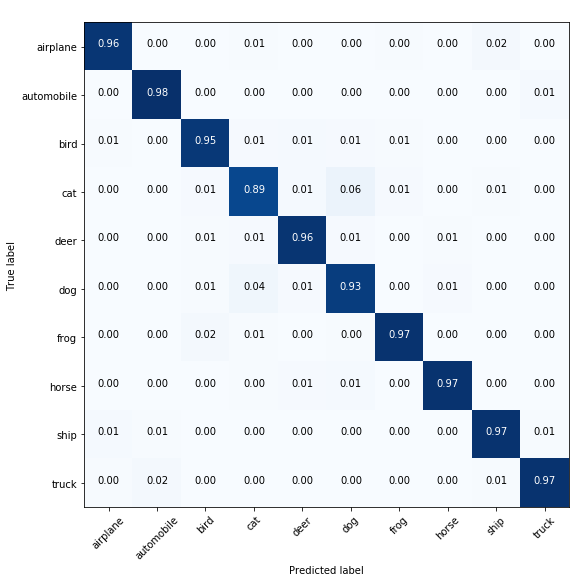

In [13]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure( figsize=(8,8))
plot_confusion_matrix(mc, classes=data.data.classes, title=' ')
plt.show()